# Импортируем нужные библиотеки

In [2]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

# Загружаем данные

In [3]:
train = pd.read_csv('03_santander_train.csv', index_col='ID')
train.shape

(76020, 370)

In [4]:
test = pd.read_csv('03_santander_test.csv', index_col='ID')
test.shape

(75818, 369)

In [5]:
y = list(train['TARGET'])
train = train.drop('TARGET', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Columns: 369 entries, var3 to var38
dtypes: float64(111), int64(258)
memory usage: 214.6 MB


In [6]:
# Соеденим train и test в all_data
train['is_test'] = False
test['is_test'] = True
all_data = pd.concat([train, test])
all_data.shape

(151838, 370)

In [7]:
train.info(verbose=False, memory_usage=True, null_counts=True) # выводим список всех фичей

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Data columns (total 370 columns):
var3                             76020 non-null int64
var15                            76020 non-null int64
imp_ent_var16_ult1               76020 non-null float64
imp_op_var39_comer_ult1          76020 non-null float64
imp_op_var39_comer_ult3          76020 non-null float64
imp_op_var40_comer_ult1          76020 non-null float64
imp_op_var40_comer_ult3          76020 non-null float64
imp_op_var40_efect_ult1          76020 non-null float64
imp_op_var40_efect_ult3          76020 non-null float64
imp_op_var40_ult1                76020 non-null float64
imp_op_var41_comer_ult1          76020 non-null float64
imp_op_var41_comer_ult3          76020 non-null float64
imp_op_var41_efect_ult1          76020 non-null float64
imp_op_var41_efect_ult3          76020 non-null float64
imp_op_var41_ult1                76020 non-null float64
imp_op_var39_efect_ult1          76020 non-null float

In [8]:
# Разделим снова all_data на train и test по ранее сделанным меткам
train = all_data[~all_data.is_test].drop(['is_test'], axis=1)
test = all_data[all_data.is_test].drop(['is_test'], axis=1)
train.shape

(76020, 369)

In [9]:
# Разобьем наш train датасет на train X_train и X_test
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)

# Вспомогательные функции

In [10]:
def draw_hist(_y, result_predicts, xlim=(-1, 15), ylim=(-0.01, 1.01), size=(5,10)):
    steps = []
    scores = []
    for data in result_predicts:
        predict_prob, step = data
        score = roc_auc_score(_y, predict_prob[:,1])
        steps.append(step)
        scores.append(score)
    
    plt.figure(figsize=size)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("steps")
    plt.ylabel("ROC_AUC")
    plt.bar(steps, scores)

In [11]:
def cal_predict(x_train, y_train, x_test, blackbox):
    """
    Строим модель прогнозирования
    
    @return predict, predict_proba 
    """
    model = blackbox # у квалификатора есть своё случайное значение.
    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    predict_proba = model.predict_proba(x_test)
    return predict, predict_proba

In [12]:
def draw_roc_auc_multy(y_test, result_predicts):
    plt.figure(figsize=(5, 10))
    plt.plot([0, 1], [0, 1])
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    plt.grid(True)
    plt.xlim((-0.01, 1.01))
    plt.ylim((-0.01, 1.01))
    for data in result_predicts:
        predict_prob, depth = data
        score = roc_auc_score(y_test, predict_prob[:,1])
        fpr, tpr, thresholds = roc_curve(y_test, predict_prob[:,1])
        plt.plot(fpr, tpr, label=f'ROC {score:.3f} {depth}')
    plt.legend( borderaxespad=0.)

# Строим DecisionTreeClassifier

In [13]:
dtc = DecisionTreeClassifier(max_depth=5)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [14]:
predict_probs=[]
for depth in tqdm(range(1,15,2)):
    blackbox = DecisionTreeClassifier(max_depth=depth, random_state=42)
    predict, predict_prob = cal_predict(
        x_train=X_train,
        x_test=X_test,
        y_train=y_train,
        blackbox=blackbox
    )
    predict_probs.append((predict_prob, depth))

100%|████████████████████████████████████████████| 7/7 [00:12<00:00,  1.76s/it]


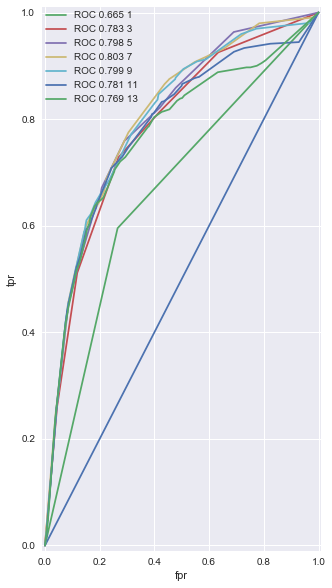

In [15]:
draw_roc_auc_multy(y_test, predict_probs)

In [16]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [17]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
roc_auc_score(y_test, dtc.predict_proba(X_test)[:,1])

0.79758999655598939

In [19]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.59791750840566427

In [20]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])

0.53160087115379717

https://www.kaggle.com/cast42/exploring-features